In [1]:
!pip install torchnet

     |████████████████████████████████| 676 kB 7.7 MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29745 sha256=fbfa4b0b483aeb01314fac408b2f83e867603ae52729d9d87edc5a5b5b482b31
  Stored in directory: /root/.cache/pip/wheels/93/17/b3/86db1d93e9dae198813aa79831b403e4844d67986cf93894b5
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655249 sha256=b5778f8df47d67188ee6fba2a0d7ae19505486d69d4bc91b33528e9d83fcb71e
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5711 sha256=4823a8e21b3913d2bb3b9efdee57b57c561430d1b90e3ddf72acca39c4b44610
  Stored in directory: /root/.cache/pip/wheels/ac/5c/3a/a80e1c65880945c71fd833408cd1e9a8cb7e2f8f37620bb75b
Successfully built torchnet visdom torchfile


In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torchnet.meter.confusionmeter as cm

In [3]:
train_image_dir = '../input/train/'
test_image_dir = '../input/test/'

# Loading csv files
train_data = pd.read_csv('../input/train.csv')
#train_data.head()

In [4]:
print('No of classes : {}\nClasses : {}'.format(len(train_data['target'].unique()),train_data['target'].unique()))

No of classes : 8
Classes : ['manipuri' 'bharatanatyam' 'odissi' 'kathakali' 'kathak' 'sattriya'
 'kuchipudi' 'mohiniyattam']


In [5]:
train_image_names = os.listdir(train_image_dir)
print(len(train_image_names))
print(train_data.shape[0])

train_image_names = set(train_image_names)
info_images = set(train_data['Image'])
no_info_images = train_image_names - info_images
print(no_info_images)

364
364
set()


In [6]:
train_data['Image'].apply(lambda t : t.split('.')[-1]).unique()

array(['jpg'], dtype=object)

**Conclusion** : All images are of one extension '.jpg'

In [7]:
class_names = ['manipuri', 'bharatanatyam', 'odissi', 'kathakali', 'kathak', 'sattriya', 'kuchipudi', 'mohiniyattam']

In [8]:
class_encoding = {
    'manipuri':0,
    'bharatanatyam':1,
    'odissi':2,
    'kathakali':3,
    'kathak':4,
    'sattriya':5,
    'kuchipudi':6,
    'mohiniyattam':7,}

get_labels = {v: k for k, v in class_encoding.items()}

train_data['target'] = train_data['target'].map(class_encoding)
train_data['Image'] = train_data['Image'].apply(lambda t : os.path.join(train_image_dir, t))
train_data.head()

,Image,target
0,../input/train/96.jpg,0
1,../input/train/163.jpg,1
2,../input/train/450.jpg,2
3,../input/train/219.jpg,3
4,../input/train/455.jpg,2


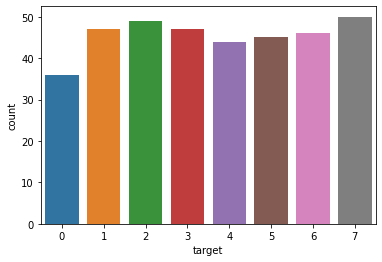

In [9]:
sns.countplot(x = 'target', data = train_data)

In [10]:
import torch
import torch.nn as nn
from torchvision import transforms, utils, models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import time
import copy
from torch.optim import lr_scheduler
from PIL import Image

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
class Dance (Dataset) :
    def __init__(self, dataframe, image_dir, transformations = None) :
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transforms = transformations
        self.to_tensor = transforms.ToTensor()
        # Modify image names to contain path
        
    def __getitem__(self, idx) :
        image_path = self.dataframe['Image'][idx]
        image_class = self.dataframe['target'][idx]
        #print(image_path)
        image = Image.open(image_path)
        # apply transformations
        if self.transforms is not None :
            image = self.transforms(image)
        #image = self.to_tensor(image)
        return (image, image_class)
    
    def __len__(self) :
        return self.dataframe.shape[0]
    
class Dance_test(Dataset) :
    def __init__(self, image_dir, transformations = None) :
        self.image_dir = image_dir
        self.images = os.listdir(self.image_dir)
        self.images_with_paths = [os.path.join(self.image_dir, x) for x in os.listdir(self.image_dir)]
        self.transforms = transformations
        self.to_tensor = transforms.ToTensor()
        # Modify image names to contain path
        
    def __getitem__(self, idx) :
        image_name = self.images[idx]
        image_path = self.images_with_paths[idx]
        #print(image_path)
        image = Image.open(image_path)
        # apply transformations
        if self.transforms is not None :
            image = self.transforms(image)
        #image = self.to_tensor(image)
        return image_name, image
    
    def __len__(self) :
        return len(self.images)

In [13]:
data_transforms = {'train': transforms.Compose([transforms.Resize ((256, 256)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225]),]),
                   'val' : transforms.Compose([transforms.Resize ((256, 256)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225]),]),
                   'test' : transforms.Compose([transforms.Resize ((256, 256)),
                                      transforms.CenterCrop(256),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225]),])}

test_transforms = transforms.Compose([transforms.Resize ((256, 256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225]),])


train_images = Dance(train_data, train_image_dir, transformations = data_transforms['train'])
test_images = Dance_test(test_image_dir, transformations = test_transforms)

In [14]:
ex_image, ex_label = train_images[0]
print(ex_image.shape)
print(type(ex_image))
print(ex_label)

torch.Size([3, 256, 256])
<class 'torch.Tensor'>
0


In [15]:
def get_train_valid_splits(dataset, batch_size = 4, validation_split = .3, shuffle_dataset = True, random_seed= 23, test = False) :
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    
    if test :
        dataset_size = split
        indices = list(range(dataset_size))
        split = int(np.floor(validation_split * dataset_size))
        if shuffle_dataset :
            np.random.seed(random_seed)
            np.random.shuffle(indices)
        val_indices, test_indices = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler  = SubsetRandomSampler(val_indices)
        test_sampler  = SubsetRandomSampler(test_indices)
        return train_sampler, valid_sampler, test_sampler

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler  = SubsetRandomSampler(val_indices)
    
    return train_sampler, valid_sampler 

#train_sampler, valid_sampler  = get_train_valid_splits(train_images)
train_sampler, valid_sampler, test_sampler  = get_train_valid_splits(train_images, test = True)

In [16]:
batch_size = 4
train_image_loader = DataLoader(dataset = train_images,
                                sampler = train_sampler,
                                batch_size = batch_size,
                               num_workers = batch_size)
    
valid_image_loader = DataLoader(dataset = train_images,
                               sampler = valid_sampler ,
                                batch_size = batch_size,
                               num_workers = batch_size)

test_image_loader = DataLoader(dataset = train_images,
                               sampler = test_sampler ,
                                batch_size = batch_size,
                              num_workers = batch_size)

In [17]:
test_loader = DataLoader(dataset = test_images,
                        batch_size = batch_size,
                        num_workers = batch_size)

In [18]:
print('Final Test Images:', len(test_loader) * batch_size)

Final Test Images: 156


In [19]:
print('Train Images : ', len(train_image_loader) * batch_size)
print('Validation Images  ', len(valid_image_loader) * batch_size)

Train Images :  256
Validation Images   80


In [20]:
dataloaders = {'train' : train_image_loader, 'val' : valid_image_loader}

Image Dtype: <class 'torch.Tensor'>
Image Batch Shape: torch.Size([4, 3, 256, 256])
Labels:  ['sattriya', 'kuchipudi', 'sattriya', 'kuchipudi']


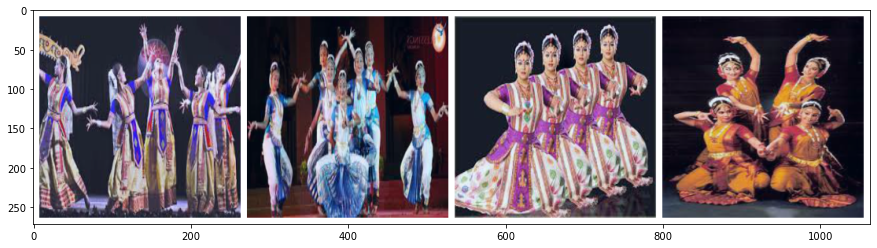

In [21]:
def plot_images(train_image_loader, padding= 8, pad_value = 255) :
    for batch_idx, (images, labels) in enumerate(train_image_loader):
        print('Image Dtype:',type(images))
        print('Image Batch Shape:',images.shape)
        #print('labels Batch Shape:',labels.shape)
        classes = [get_labels[x] for x in np.array(labels)]
        print('Labels: ', classes)

        # We do single_batch[0] because each batch is a list 
        # where the 0th index is the image tensor and 1st index is the
        # output label.
        single_batch_grid = utils.make_grid(images, nrow=4, normalize=True, padding= padding, pad_value = pad_value)
        plt.figure(figsize = (15,15))
        plt.imshow(single_batch_grid.permute(1, 2, 0))
        break
        
plot_images(train_image_loader)

In [22]:
classifier = models.resnet18(pretrained=True)
num_ftrs = classifier.fc.in_features
classifier.fc = nn.Linear(num_ftrs, 8)

#for VGG16_BN
#model_ft = models.vgg16_bn(pretrained=True)
#model_ft.classifier[6].out_features = 8

classifier = classifier.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [23]:
#dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
epoch_counter_train = []
epoch_counter_val = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

In [24]:

def train_model(model, criterion, optimizer, scheduler, data_loader, num_epochs = 3) :
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs) :
        print('Epoch {}/{}'.format(epoch +1, num_epochs))
        print('-' * 10)
        # each model has training and validation phase
        for phase in ['train','val'] :
            if phase == 'train' :
                scheduler.step()
                model.train() # Set model to training mode
            else :
                model.eval() # Set model to evaluation mode
            running_loss = 0.0
            running_corrects = 0
            
            #Iterate over data
            d_size = 0
            for batch, (inputs, labels) in enumerate(dataloaders[phase]) :
                d_size += 1
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero previous gradients
                optimizer.zero_grad()
                
                # Forward Pass
                # Pass history in train phase
                with torch.set_grad_enabled(phase == 'train') :
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        
            #For graph generation
            if phase == "train":
                train_loss.append(running_loss/(d_size * batch_size))
                train_acc.append(running_corrects.double() / (d_size * batch_size))
                epoch_counter_train.append(epoch)
            if phase == "val":
                val_loss.append(running_loss/ (d_size * batch_size))
                val_acc.append(running_corrects.double() / (d_size * batch_size))
                epoch_counter_val.append(epoch)

            epoch_loss = running_loss / (d_size * batch_size)
            epoch_acc = running_corrects.double() / (d_size * batch_size)

            #for printing        
            if phase == "train":    
                epoch_loss = running_loss / (d_size * batch_size)
                epoch_acc = running_corrects.double() / (d_size * batch_size)
            if phase == "val":    
                epoch_loss = running_loss / (d_size * batch_size)
                epoch_acc = running_corrects.double() / (d_size * batch_size)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [25]:
criterion = nn.CrossEntropyLoss()

# Using Adam as the parameter optimizer
optimizer_ft = optim.Adam(classifier.parameters(), lr = 0.0001, betas=(0.9, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)       


classifier = train_model(classifier, criterion, optimizer_ft, exp_lr_scheduler, train_image_loader, num_epochs= 10)        


Epoch 1/10
----------


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.5547 Acc: 0.4492
val Loss: 0.5780 Acc: 0.8250

Epoch 2/10
----------
train Loss: 0.7352 Acc: 0.7891
val Loss: 0.2946 Acc: 0.9000

Epoch 3/10
----------
train Loss: 0.3861 Acc: 0.9141
val Loss: 0.3658 Acc: 0.8625

Epoch 4/10
----------
train Loss: 0.2089 Acc: 0.9688
val Loss: 0.2463 Acc: 0.8875

Epoch 5/10
----------
train Loss: 0.2758 Acc: 0.9336
val Loss: 0.2380 Acc: 0.9000

Epoch 6/10
----------
train Loss: 0.2223 Acc: 0.9453
val Loss: 0.2157 Acc: 0.9000

Epoch 7/10
----------
train Loss: 0.2397 Acc: 0.9375
val Loss: 0.2307 Acc: 0.8750

Epoch 8/10
----------
train Loss: 0.1287 Acc: 0.9844
val Loss: 0.2295 Acc: 0.8875

Epoch 9/10
----------
train Loss: 0.1649 Acc: 0.9766
val Loss: 0.1810 Acc: 0.9125

Epoch 10/10
----------
train Loss: 0.1462 Acc: 0.9805
val Loss: 0.2074 Acc: 0.8875

Training complete in 1m 5s
Best val Acc: 0.912500


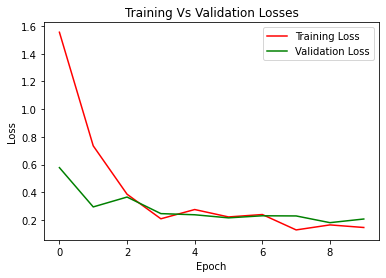

In [26]:
#Plot the train & validation losses
plt.figure(1)
plt.title("Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoch_counter_train,train_loss,color = 'r', label="Training Loss")
plt.plot(epoch_counter_val,val_loss,color = 'g', label="Validation Loss")
plt.legend()
plt.show()


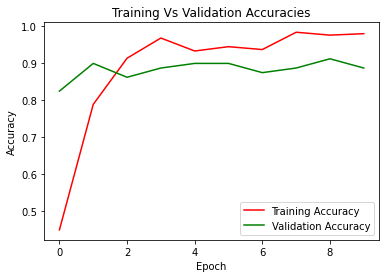

In [27]:
#Plot the accuracies in train & validation
plt.figure(2)
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epoch_counter_train,train_acc,color = 'r', label="Training Accuracy")
plt.plot(epoch_counter_val,val_acc,color = 'g', label="Validation Accuracy")
plt.legend()
plt.show()

In [28]:
#Test the accuracy with test data
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_image_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = classifier(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 96 %


In [29]:
#Class wise testing accuracy
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_image_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = classifier(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

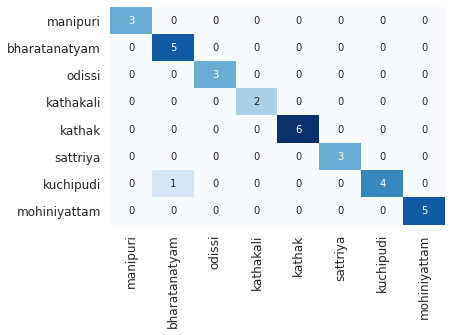

In [30]:
#Get the confusion matrix for testing data
confusion_matrix = cm.ConfusionMeter(8)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_image_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = classifier(inputs)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    #print(confusion_matrix.conf)

#Confusion matrix as a heatmap
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sns.set(font_scale= 1.1)
sns.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues") 


In [31]:
#Test the accuracy with test data
preds = []
names = []
total = 0
with torch.no_grad():
    for i, (name, inputs) in enumerate(test_loader):
            inputs = inputs.to(device)
            outputs = classifier(inputs)
            _, predicted = torch.max(outputs.data, 1)
            names.append(name)
            preds.append(predicted)

# print(names)
# print(preds)

In [32]:
for i in range(len(preds)):
    preds[i] = preds[i].cpu().numpy()

In [33]:
preds = np.array(preds).ravel()
preds = [get_labels[e] for e in preds] 
names = np.array(names).ravel()
print(preds[:10])
print(names[:10])

['bharatanatyam', 'kuchipudi', 'odissi', 'bharatanatyam', 'bharatanatyam', 'kathakali', 'kathak', 'odissi', 'mohiniyattam', 'mohiniyattam']
['170.jpg' '438.jpg' '458.jpg' '510.jpg' '138.jpg' '238.jpg' '38.jpg'
 '479.jpg' '264.jpg' '278.jpg']


In [34]:
sub = pd.DataFrame({'Image':names, 'target':preds})
sub.head()

,Image,target
0,170.jpg,bharatanatyam
1,438.jpg,kuchipudi
2,458.jpg,odissi
3,510.jpg,bharatanatyam
4,138.jpg,bharatanatyam


In [35]:
sub.to_csv('Submission.csv', index = False)